# Demo: Linear Congruential Generator (LCG) Prediction with Fixed Modulus (FM)

This notebook demonstrates how to load and use pre-trained transformer models for predicting Linear Congruential Generator (LCG) sequences with fixed modulus (FM).

## Overview

- **LCG Formula**: $X_{n+1} = a \cdot X_n + c \pmod m$
- **Task**: Given a sequence of LCG values, predict the next values in the sequence


**Model Architecture:**
- 1024-dim embeddings, 8-head, 2-layer GPT-style transformer with abacus positional embeddings




## 1. Setup & Model Loading

### Environment Setup


In [1]:
# Import necessary libraries
import sys
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
from tqdm.auto import tqdm

# Add project root to path for imports
sys.path.append('..')
from utils.gpt2 import GPTConfig_abacus, GPT_oth_abacus
from utils.datasets import BaseBLCG
from utils.prng_data import find_as, find_coprimes
from utils.eval import load_pretrained_model, get_predictions, predict_next_tokens, evaluate_test_accuracy

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("Environment setup complete")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {torch.cuda.get_device_name() if torch.cuda.is_available() else 'CPU only'}")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Environment setup complete
PyTorch version: 2.2.2
Device available: CPU only


### Pre-trained Model Loading


In [2]:

MODEL_PATH = "../models/params_p4294967296_b256_d4_sl512_na1024_nc1024_ne1_n1024_h8_d2_ds71_I9_lr0.000100_Twarm5000_T200000_B512_wd1.00.pth"

try:
    # Using the wrapped function from utils.eval  
    model, config_params = load_pretrained_model(MODEL_PATH)
    device = next(model.parameters()).device
except Exception as e:
    print(f"Error loading model: {e}")


Model Configuration:
  n_embd      : 1024
  n_head      : 8
  n_layer     : 2
  p           : 4294967296
  base        : 256
  digits      : 4
  seq_len     : 512
  vocab_size  : 256
  context_len : 2047
✅ Successfully loaded pre-trained model from:
   ../models/params_p4294967296_b256_d4_sl512_na1024_nc1024_ne1_n1024_h8_d2_ds71_I9_lr0.000100_Twarm5000_T200000_B512_wd1.00.pth
   Device: mps
   Total parameters: 25,985,024
   Trainable parameters: 25,985,024


## 3. LCG Sequence Generation


Now let's demonstrate BLCG sequence generation using the model's configuration parameters:


In [3]:
# Extract parameters from loaded model
p = config_params['p']          # 4,294,967,296 
base = config_params['base']    # 256
digits = config_params['digits'] # 4
seq_len = config_params['seq_len'] # 512


# Model Accuracy Evaluation
print("\n" + "="*60)
print("MODEL ACCURACY EVALUATION")
print("="*60)

# Set up test parameters
n_test_c = 8 # Reduced for demo
batch_size = 8
n_example = 1
rng_test = np.random.default_rng(4)

# Steele multipliers (known good LCG multipliers)
steele_a = [0xd9f5, 0x1dab5, 0x3d575, 0xc083c5, 0x915f77f5]

# Load training a and c values to exclude them from test
# Build path using available config parameters
train_ac_path = f"../results/trainac_p{p}_b{base}_d{digits}_sl{seq_len}_na1024_nc1024_ne1_n{config_params['n_embd']}_h{config_params['n_head']}_d{config_params['n_layer']}_ds71_I9_lr0.000100_Twarm5000_T200000_B512_wd1.00.npz"
try:
    print(f"Loading training parameters from: {train_ac_path}")
    data = np.load(train_ac_path)
    train_a = data['train_a']
    train_c = data['train_c']
    print(f"Loaded {len(train_a)} training a values and {len(train_c)} training c values")
    
    # Generate test values excluding training ones
    val_c_all = find_coprimes(p, num=n_test_c + len(train_c) + 100, rng=rng_test)
    val_c = np.setdiff1d(val_c_all, train_c)[:n_test_c]
    
    n_test_a = 64  # Reduced for demo
    val_a_all = find_as(p=p, num=n_test_a + len(train_a) + 100, rng=rng_test)
    val_a = np.setdiff1d(val_a_all, train_a)[:n_test_a]
    val_a.sort()
    
    # Also exclude training values from Steele multipliers
    steele_a = np.setdiff1d(steele_a, train_a)
    print(f"Training values excluded")
    
except FileNotFoundError:
    print(f"Training parameters file not found, using all generated values")
    print("   (This means test sets may include training values)")
    val_c = find_coprimes(p, num=n_test_c + 100, rng=rng_test)[:n_test_c]
    n_test_a = 64
    val_a = find_as(p=p, num=n_test_a, rng=rng_test)

print(f"Test setup: {len(steele_a)} Steele multipliers, {len(val_a)} arbitrary multipliers, {len(val_c)} c values")

# Demonstrate BLCG sequence format
print("\n" + "="*60)
print("BLCG SEQUENCE DEMONSTRATION")
print("="*60)

# Generate a small demo sequence
demo_a = steele_a[0] if len(steele_a) > 0 else val_a[0]
demo_c = val_c[0]
demo_length = 10  # Short sequence for demo

print(f"Demo LCG parameters: a={demo_a}, c={demo_c}, m={p:,}")

# Generate demo sequence
from utils.prng_data import base_b_lcg
demo_tokens = base_b_lcg(
    base=base, digits=digits, p=p, length=demo_length,
    a=demo_a, c=demo_c, rng=rng_test, num_examples=1
).squeeze(0)

# Convert tokens to decimal values
demo_decimal = []
for i in range(0, len(demo_tokens), digits):
    tokens_group = demo_tokens[i:i+digits].tolist()
    decimal_val = sum(token * (base ** idx) for idx, token in enumerate(tokens_group)) % p
    demo_decimal.append(decimal_val)

print(f"\nSequence in decimal: {demo_decimal}")
print(f"Sequence in base-{base} tokens: {demo_tokens.tolist()}")

# Show input/target format (how model sees the data)
print(f"\nInput/Target format:")
print(f"  Input tokens:  {demo_tokens[:-1].tolist()}")
print(f"  Target tokens: {demo_tokens[1:].tolist()}")
print(f"  (Target is input shifted by 1 position)")




MODEL ACCURACY EVALUATION
Loading training parameters from: ../results/trainac_p4294967296_b256_d4_sl512_na1024_nc1024_ne1_n1024_h8_d2_ds71_I9_lr0.000100_Twarm5000_T200000_B512_wd1.00.npz
Loaded 1024 training a values and 1024 training c values
Training values excluded
Test setup: 5 Steele multipliers, 64 arbitrary multipliers, 8 c values

BLCG SEQUENCE DEMONSTRATION
Demo LCG parameters: a=55797, c=1869217, m=4,294,967,296

Sequence in decimal: [185589872, 193806545, 3392976550, 50989183, 1776963116, 4187791805, 2820441218, 263817227, 1358760744, 12393193]
Sequence in base-256 tokens: [112, 224, 15, 11, 209, 64, 141, 11, 166, 182, 60, 202, 127, 8, 10, 3, 44, 78, 234, 105, 189, 161, 156, 249, 130, 132, 28, 168, 11, 136, 185, 15, 40, 11, 253, 80, 233, 26, 189, 0]

Input/Target format:
  Input tokens:  [112, 224, 15, 11, 209, 64, 141, 11, 166, 182, 60, 202, 127, 8, 10, 3, 44, 78, 234, 105, 189, 161, 156, 249, 130, 132, 28, 168, 11, 136, 185, 15, 40, 11, 253, 80, 233, 26, 189]
  Target to

Test the model’s performance on sequences generated using unseen values of ‘a’ and ‘c’. Steele multipliers are specific ‘a’ values that provide good spectral properties for LCGs, in addition to ensuring a full period.

In [4]:
# Test 1: Steele Multipliers using new function
print("\nTesting Steele multipliers...")
steele_results = evaluate_test_accuracy(
    test_a=steele_a, 
    test_c=val_c, 
    model=model,
    p=p, 
    base=base, 
    digits=digits, 
    seq_len=seq_len,
    batch_size=batch_size, 
    n_example=n_example, 
    rng=rng_test
)

steele_acc = steele_results['accuracy']

# Test 2: Arbitrary Multipliers using new function
print("\nTesting arbitrary multipliers...")
arbitrary_results = evaluate_test_accuracy(
    test_a=val_a, 
    test_c=val_c, 
    model=model,
    p=p, 
    base=base, 
    digits=digits, 
    seq_len=seq_len,
    batch_size=batch_size, 
    n_example=n_example, 
    rng=rng_test
)

arbitrary_acc = arbitrary_results['accuracy']

# Results Summary
print(f"\nACCURACY RESULTS:")
print(f"   Steele multipliers:    {steele_results['mean_accuracy']:.3f} ± {steele_results['std_accuracy']:.3f}")
print(f"   Arbitrary multipliers: {arbitrary_results['mean_accuracy']:.3f} ± {arbitrary_results['std_accuracy']:.3f}")
print(f"   Final position accuracy: Steele={steele_results['final_accuracy']:.3f}, Arbitrary={arbitrary_results['final_accuracy']:.3f}")


Testing Steele multipliers...
Evaluating test accuracy with:
  Test a values: 5
  Test c values: 8
  Parameters: p=4294967296, base=256, digits=4, seq_len=512
  Dataset size: 40 sequences

Testing arbitrary multipliers...
Evaluating test accuracy with:
  Test a values: 64
  Test c values: 8
  Parameters: p=4294967296, base=256, digits=4, seq_len=512
  Dataset size: 512 sequences

ACCURACY RESULTS:
   Steele multipliers:    0.665 ± 0.440
   Arbitrary multipliers: 0.734 ± 0.380
   Final position accuracy: Steele=1.000, Arbitrary=1.000


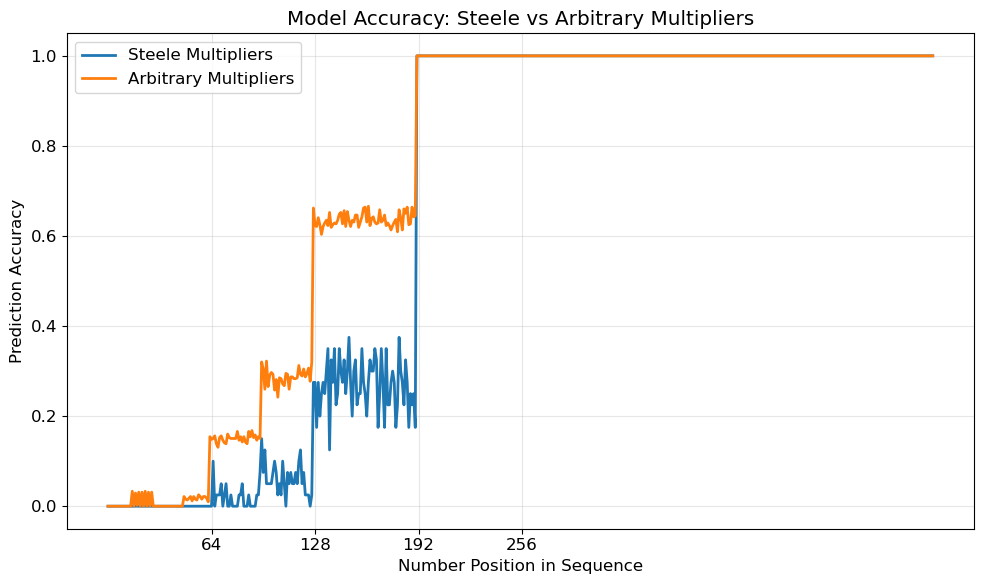

In [6]:
# Quick visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
positions = np.arange(len(steele_acc))
ax.plot(positions, steele_acc, label='Steele Multipliers', linewidth=2, markersize=4)
ax.plot(positions, arbitrary_acc, label='Arbitrary Multipliers', linewidth=2, markersize=4)
ax.set_xlabel('Number Position in Sequence')
ax.set_ylabel('Prediction Accuracy')
ax.set_title('Model Accuracy: Steele vs Arbitrary Multipliers')
ax.legend()
ax.grid(True, alpha=0.3)
xticks = [64, 128, 192, 256]
ax.set_xticks(xticks)
plt.tight_layout()
plt.show()